In [1]:
from default import *
%cd -q {PROJECT_HOME}

import numpy as np
from dataset import DummyTrussDataset
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from losses import NodeEquilibriumLoss, StiffnessToLoadLoss, EnergyLoss
from models.processing import StandardScaler
from models.architecture import MLP
from torchmetrics import MeanAbsolutePercentageError

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

from matplotlib import pyplot as plt

ds_train = DummyTrussDataset("data/dataset/dummy_truss/4096.hdf5")
ds_val = DummyTrussDataset("data/dataset/dummy_truss/val_512.hdf5")

dl_train = DataLoader(ds_train, batch_size=512)
dl_val = DataLoader(ds_val, batch_size=512)

device = 'mps'

mape = MeanAbsolutePercentageError().to(device)
N_EPOCH = 200
LR = 1e-3



In [6]:
def model = MLP(11, [50]*3, 5, activation='tanh', activation_params=None).to(device)

optimizer = Adam(lr=LR, params=model.parameters())
loss_fn = nn.MSELoss().to(device)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, factor=.5)

x_scaler = StandardScaler(11).to(device)
y_scaler = StandardScaler(5).to(device)
for x, y, _, _, _, _ in dl_train:
    x_scaler.partial_fit(x.to(device))
    y_scaler.partial_fit(y.to(device))

losses = []
val_losses = []
for epoch in range(N_EPOCH):
    loss_step = []
    for x, y, _, _, _, _ in dl_train:
        x = x.to(device)
        y = y.to(device)

        z_x = x_scaler.transform(x)
        z_y = y_scaler.transform(y)

        z_y_pred = model(z_x)
        y_pred = y_scaler.inverse_transform(z_y_pred)

        optimizer.zero_grad()
        loss = loss_fn(z_y_pred, z_y)
        loss.backward()
        loss_step.append(loss.item())
        optimizer.step()
    losses.append(np.mean(loss_step))

    for x, y, _, _, _, _ in dl_val:
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)

            z_x = x_scaler.transform(x)
            z_y = y_scaler.transform(y)

            z_y_pred = model(z_x)
            y_pred = y_scaler.inverse_transform(z_y_pred)

            loss = loss_fn(z_y_pred, z_y)
            val_losses.append(loss.item())

    scheduler.step(torch.tensor(val_losses).mean())

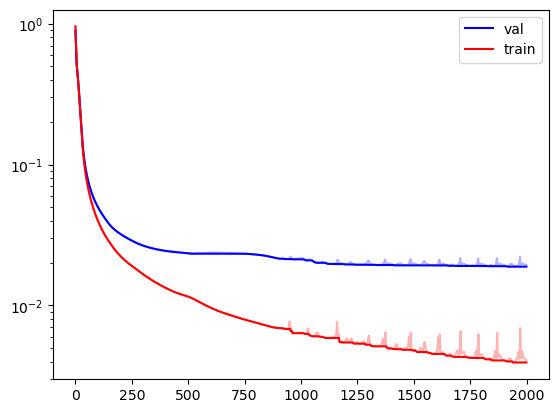

MAPE: 0.038


In [11]:
plt.plot(val_losses, color='b', alpha=.3)
plt.plot(losses, color='r', alpha=.3)
plt.plot(np.minimum.accumulate(val_losses), color='b', label='val')
plt.plot(np.minimum.accumulate(losses), color='r', label='train')
plt.yscale('log')
plt.legend()
plt.show()

for x, y, _, _, _, _ in dl_val:
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)

        z_x = x_scaler.transform(x)
        z_y = y_scaler.transform(y)

        z_y_pred = model(z_x)
        y_pred = y_scaler.inverse_transform(z_y_pred)

        print(f"MAPE: {mape(y_pred, y):.3f}")

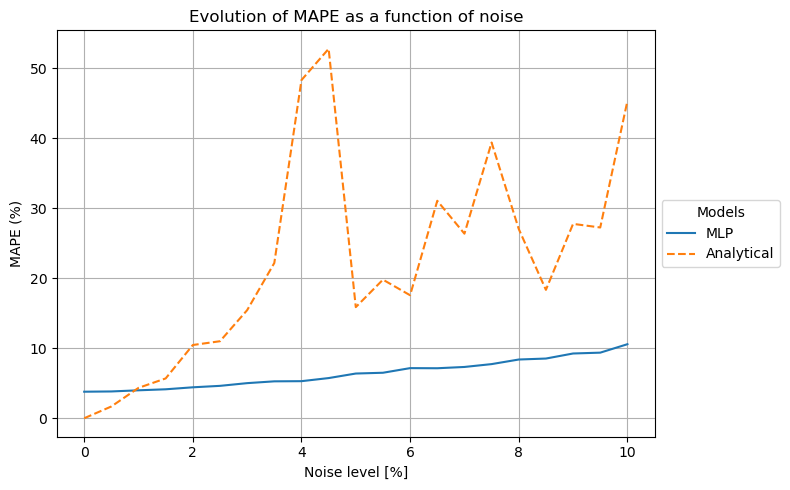

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the noise levels
noise_levels = np.linspace(0, 0.1, 21)

mapes = []
for noise in noise_levels:
    ds = DummyTrussDataset('data/dataset/dummy_truss/val_512.hdf5',
                           f_noise_loads=lambda size: np.random.normal(1, noise / 2, size),
                           f_noise_displacement=lambda size: np.random.normal(1, noise / 2, size),
                           f_noise_strain=lambda size: np.random.normal(1, noise / 2, size)
                           )
    dl = DataLoader(ds, batch_size=512)

    mapes_epoch = []
    for x, y, _, _, _, _ in dl:
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)

            z_x = x_scaler.transform(x)
            z_y = y_scaler.transform(y)

            z_y_pred = model(z_x)
            y_pred = y_scaler.inverse_transform(z_y_pred)

            mapes_epoch.append(mape(y_pred, y))
    mapes.append(torch.tensor(mapes_epoch).mean())

mapes = torch.tensor(mapes)

fig, ax = plt.subplots(figsize=(8, 5))  # Wider figure for space

# MAPE Plot
ax.plot(noise_levels * 100,  mapes* 100, label='MLP')

# Analytical benchmark
analytical_results = np.loadtxt(r'experiments/dummy_truss/analytical_mean_mape.dat')
ax.plot(noise_levels * 100, analytical_results * 100, linestyle='--', label="Analytical")

# Labels and formatting
ax.set_ylabel("MAPE (%)")
ax.set_title("Evolution of MAPE as a function of noise")
ax.set_xlabel("Noise level [%]")
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Models")

plt.tight_layout()  # Make room for legend

# Save
#fig.savefig(r"experiments/dummy_truss/03_truss_example_classical_model_noise_mape.pdf")

plt.show()


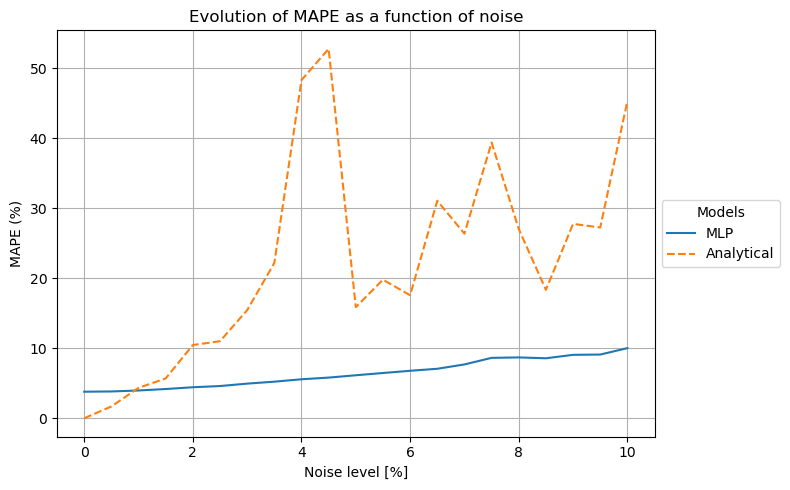

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the noise levels
noise_levels = np.linspace(0, 0.1, 21)

mapes = []
for noise in noise_levels:
    ds = DummyTrussDataset('data/dataset/dummy_truss/val_512.hdf5',
                           f_noise_loads=lambda size: np.random.normal(1, noise / 2, size),
                           f_noise_displacement=lambda size: np.random.normal(1, noise / 2, size),
                           f_noise_strain=lambda size: np.random.normal(1, noise / 2, size)
                           )
    dl = DataLoader(ds, batch_size=512)

    mapes_epoch = []
    for x, y, _, _, _, _ in dl:
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)

            z_x = x_scaler.transform(x)
            z_y = y_scaler.transform(y)

            z_y_pred = model(z_x)
            y_pred = y_scaler.inverse_transform(z_y_pred)

            mapes_epoch.append(mape(y_pred, y))
    mapes.append(torch.tensor(mapes_epoch).mean())

mapes = torch.tensor(mapes)

fig, ax = plt.subplots(figsize=(8, 5))  # Wider figure for space

# MAPE Plot
ax.plot(noise_levels * 100,  mapes* 100, label='MLP')

# Analytical benchmark
analytical_results = np.loadtxt(r'experiments/dummy_truss/analytical_mean_mape.dat')
ax.plot(noise_levels * 100, analytical_results * 100, linestyle='--', label="Analytical")

# Labels and formatting
ax.set_ylabel("MAPE (%)")
ax.set_title("Evolution of MAPE as a function of noise")
ax.set_xlabel("Noise level [%]")
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Models")

plt.tight_layout()  # Make room for legend

# Save
#fig.savefig(r"experiments/dummy_truss/03_truss_example_classical_model_noise_mape.pdf")

plt.show()